In [1]:
import torch
import torchvision
import numpy as np
import os 
from PIL import Image
import matplotlib.pyplot as plt
from math import sqrt
from math import floor
import time

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

### HYPER-PARAMS

In [3]:
save_root = '../storage/data/AS_storage/generatedImages/'

batch_size = 64
num_workers = 1

image_width = 256
image_height = 256

num_epochs = 11
lr = 0.0002
k = 2

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((268,268)),
    torchvision.transforms.RandomCrop((image_width, image_height)),
    torchvision.transforms.Lambda(lambda image: (np.array(image) / 127.5) -1),
    torchvision.transforms.ToTensor(),
])

### DATAROOT

In [4]:
dataset_dir = '../storage/data/AS_storage/facades/'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

### CUSTOM DATASET

In [5]:
class FacadesDataset():
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.images = list(sorted(os.listdir(root)))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.root, self.images[idx])
        image = np.array(Image.open(image_path).convert('RGB'))
        h,w,d = image.shape
        w = w//2
        real_image = image[:, :w, :]
        label_image = image[:, w:, :]
        
        if self.transform is not None:
            real_image = self.transform(Image.fromarray(real_image))
            label_image = self.transform(Image.fromarray(label_image))
        
        return real_image, label_image

In [6]:
train_ds = FacadesDataset(train_dir, transform)
test_ds = FacadesDataset(test_dir, transform)
val_ds = FacadesDataset(val_dir, transform)

In [7]:
len(train_ds), len(test_ds), len(val_ds)

(400, 106, 100)

### DATALOADERS

In [8]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=num_workers)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=True, num_workers=num_workers)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size, shuffle=True, num_workers=num_workers)

In [9]:
for xb, yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([64, 3, 256, 256]) torch.Size([64, 3, 256, 256])


### HELPERS

In [10]:
def visualizeImage(image, label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,9))
    
    ax1.imshow((image).detach().cpu().permute(1,2,0))
    ax2.imshow((label).detach().cpu().permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


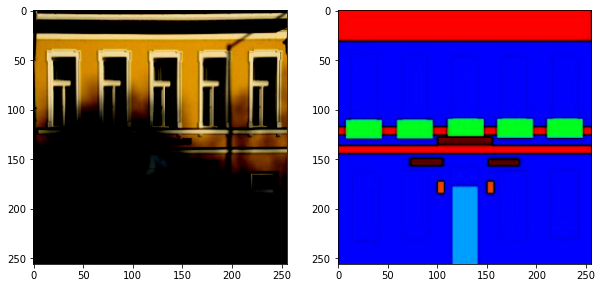

In [11]:
for xb, yb in train_dl:
    visualizeImage(xb[0], yb[0])
    break

### MODEL - DOWNSAMPLE

In [12]:
# Downsample Block
def ConvBlock(in_filters, out_filters, kernel, batch_norm, padding):
    if batch_norm:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.LeakyReLU(0.2)
        )
    else:    
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.LeakyReLU(0.2)
        )

### MODEL - UPSAMPLE

In [13]:
# Upsample Block
def ConvTransBlock(in_filters, out_filters, kernel, dropout, padding):
    if dropout:
        return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.Dropout2d(0.5),
            torch.nn.LeakyReLU(0.2)
        )
    else:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.LeakyReLU(0.2)
        )

### MODEL - GENERATOR

In [14]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.unet_down = torch.nn.Sequential(
            ConvBlock(3, 64, 4, False, 1), # (bs, 128, 128, 64)
            ConvBlock(64, 128, 4, True, 1), # (bs, 64, 64, 128)
            ConvBlock(128, 256, 4, True, 1), # (bs, 32, 32, 256)
            ConvBlock(256, 512, 4, True, 1), # (bs, 16, 16, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 8, 8, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 4, 4, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 2, 2, 512)
            ConvBlock(512, 512, 4, True, 1) # (bs, 1, 1, 512)
        )
        self.unet_up = torch.nn.Sequential(
            ConvTransBlock(512, 512, 4, True, 1), # (bs, 2, 2, 1024)
            ConvTransBlock(1024, 512, 4, True, 1), # (bs, 4, 4, 1024)
            ConvTransBlock(1024, 512, 4, True, 1), # (bs, 8, 8, 1024)
            ConvTransBlock(1024, 512, 4, False, 13), # (bs, 16, 16, 1024)
            ConvTransBlock(1024, 256, 4, False, 25), # (bs, 32, 32, 512)
            ConvTransBlock(512, 128, 4, False, 49), # (bs, 64, 64, 256)
            ConvTransBlock(256, 64, 4, False, 97) # (bs, 128, 128, 128)
        )
        self.last = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 3, 2, 2, 0, bias=False),
            torch.nn.Tanh()
        )
        
    def forward(self, inputs):
        skips = []
        for layer in self.unet_down:
            outputs = layer(inputs)
            skips.append(outputs)
            inputs = outputs
            
        rev_skips = reversed(skips[:-1])
        
        for layer, skip in zip(self.unet_up, rev_skips):
            outputs = layer(inputs)
            inputs = torch.cat((outputs, skip), 1)
            
        return self.last(inputs)

### MODEL - DISCRIMINATOR (PATCH GAN)

In [15]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.net = torch.nn.Sequential(
            ConvBlock(6, 64, 4, False, 1),  # (bs, 128, 128, 64)
            ConvBlock(64, 128, 4, True, 1),  # (bs, 64, 64, 128)
            ConvBlock(128, 256, 4, True, 1),  # (bs, 32, 32, 256)
            torch.nn.ZeroPad2d(padding=1),  # (bs, 34, 34, 256)
            torch.nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=4,
                stride=1,
                bias=False
            ),  # (bs, 31, 31, 512)
            torch.nn.BatchNorm2d(
                num_features=512
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.ZeroPad2d(padding=1),  # (bs, 33, 33, 512)
            torch.nn.Conv2d(
                in_channels=512,
                out_channels=1,
                kernel_size=4,
                stride=1,
                bias=False
            ),  # (bs, 30, 30, 1),
            torch.nn.Sigmoid()
        )
    def forward(self, inputs):
        return self.net(inputs)

### MODEL INIT

In [16]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

### LOSS/ OPTIMIZERS

In [17]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.9))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.9))

In [18]:
Lambda = 100
bce_loss = torch.nn.BCELoss()
mae_loss = torch.nn.L1Loss()

real_labels = torch.ones(batch_size, 1, 30, 30).to(device)
fake_labels= torch.zeros(batch_size, 1, 30, 30).to(device)

### TRAINING

In [19]:
# for xb, yb in train_dl:
#     print(xb.shape, yb.shape)
    
#     xb = xb.to(device).float()
#     yb = yb.to(device).float()
#     out = discriminator(torch.cat((xb, yb), 1))
#     print(out.shape)
    
#     generated = generator(xb)
#     print(generated.shape)
    
#     visualizeImage(out[0], generated[0])
    
#     break

In [20]:
def train_discriminator(src_imgs, tgt_imgs):
    
    opt_d.zero_grad()
    
    src_imgs = src_imgs.to(device).float()
    tgt_imgs = tgt_imgs.to(device).float()
    
    fake_images = generator(src_imgs)
    
    real_outputs = discriminator(torch.cat((src_imgs, tgt_imgs), 1))
    fake_outputs = discriminator(torch.cat((src_imgs, fake_images), 1))
    
    d_x = bce_loss(real_outputs, real_labels)
    d_g_x = bce_loss(fake_outputs, fake_labels)
    
    loss = d_x + d_g_x
    loss.backward()
    opt_d.step()
    
    return loss

In [21]:
start_time = time.time()

def train_generator(src_imgs, tgt_imgs):
    
    opt_g.zero_grad()
    
    src_imgs = src_imgs.to(device).float()
    tgt_imgs = tgt_imgs.to(device).float()
    
    fake_images = generator(src_imgs)
    
    outputs = discriminator(torch.cat((src_imgs, fake_images), 1))
    
    loss_a = bce_loss(outputs, real_labels)
    loss_b = mae_loss(fake_images, tgt_imgs)
    
    loss = loss_a + (Lambda*loss_b)
    loss.backward()
    opt_g.step()
    
    return loss

In [22]:
fixed_inputs, _ = next(iter(train_dl))
fixed_inputs = fixed_inputs.to(device).float()

num_steps = len(train_ds) // batch_size

D_loss  = []
G_loss = []

for epoch in range(num_epochs):
    d_loss = 0
    g_loss = 0
    
    for i, (src_images, tgt_images) in enumerate(train_dl):
        if i == num_steps:
            break
            
        for _ in range(k):
            d_loss += train_discriminator(src_images, tgt_images)
            
        d_loss /= 2
        g_loss += train_generator(src_images, tgt_images)
        
    D_loss.append(d_loss)
    G_loss.append(g_loss)
        
    if epoch % 1 == 0:
        print(f"E:{epoch} G_LOSS:{g_loss/num_steps} D_LOSS:{d_loss/num_steps} Time:{time.time() - start_time:.0f}sec")
        
#         torch.save(opt_d.state_dict(), 'section-6-pix2pix-optim-d.pytorch')
#         torch.save(opt_g.state_dict(), 'section-6-pix2pix-optim-g.pytorch')
#         torch.save(discriminator.state_dict(), 'section-6-pix2pix-network-d.pytorch')
#         torch.save(generator.state_dict(), 'section-6-pix2pix-network-g.pytorch')
        
        sample = generator(fixed_inputs).detach().cpu()
        grid = torchvision.utils.make_grid(sample.view(-1, 3, 64, 64), nrow=6, pad_value=1, normalize=True)   
        torchvision.utils.save_image(grid.detach().cpu(), os.path.join(save_root, 'PIX2PIX_FACADES_{}.jpg'.format(str(epoch).zfill(3))))

print(f'\nTOTAL DURATION: {time.time() - start_time:.0f} seconds')

E:0 G_LOSS:72.4019775390625 D_LOSS:0.3667272925376892 Time:44sec
E:1 G_LOSS:66.57661437988281 D_LOSS:0.21740704774856567 Time:86sec
E:2 G_LOSS:65.96185302734375 D_LOSS:0.14183247089385986 Time:131sec
E:3 G_LOSS:65.46891784667969 D_LOSS:0.0470011830329895 Time:176sec
E:4 G_LOSS:65.24615478515625 D_LOSS:0.09797903150320053 Time:221sec
E:5 G_LOSS:64.7840347290039 D_LOSS:0.024085596203804016 Time:266sec
E:6 G_LOSS:64.54920196533203 D_LOSS:0.013271428644657135 Time:311sec
E:7 G_LOSS:64.23246765136719 D_LOSS:0.007255599834024906 Time:356sec
E:8 G_LOSS:64.10478210449219 D_LOSS:0.0038277977146208286 Time:401sec
E:9 G_LOSS:63.8675537109375 D_LOSS:0.0020302259363234043 Time:446sec
E:10 G_LOSS:63.2186279296875 D_LOSS:0.05895392224192619 Time:491sec

TOTAL DURATION: 492 seconds


In [23]:
print(d_loss)

tensor(0.3537, device='cuda:0', grad_fn=<DivBackward0>)


torch.Size([64, 3, 256, 256]) torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 30, 30])
torch.Size([64, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


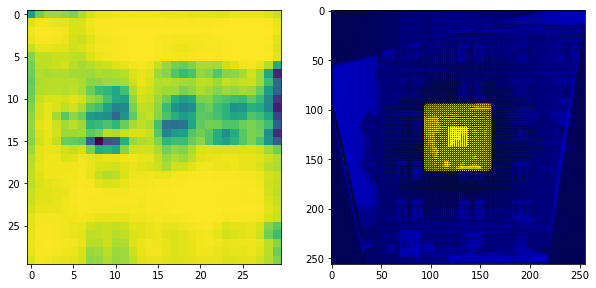

In [24]:
with torch.no_grad(): 
    for xb, yb in train_dl:
        print(xb.shape, yb.shape)

        xb = xb.to(device).float()
        yb = yb.to(device).float()
        out = discriminator(torch.cat((xb, yb), 1))
        print(out.shape)

        generated = generator(xb)
        print(generated.shape)

        visualizeImage(out[0], generated[0])

        break